## Single-cell Paper: Tara Heatmap and Histogram

* Histograms for Proch and Pelag of all gene clusters and those missing in Tara metagenomes
* Heatmaps for Proch and Pelag of Tara count vs cluster size

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import math
from sys import argv

#### Seaborn settings

In [15]:
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")

#### Function to read tsv of clusters and fix cluster size column

In [16]:
def read_clusters_tsv(path):
    df = pd.read_csv(path, sep='\t', header=0, index_col=0)
    df = df.rename(columns={'Unnamed: 1': 'cluster_size'})
    col = [int(re.sub(r'SIZE:([0-9]*)', r'\1', i)) for i in df['cluster_size']]
    df['cluster_size'] = col
    return df

#### Function to plot histograms of cluster size

In [17]:
def plot_hist_tara(df_all_clusters, df_missing_clusters, bin_max, bin_size, max_frac, num_genomes, ymax, fig_path):
    fig, ax = plt.subplots()
    sns.distplot(df_all_clusters.cluster_size, kde=False, color='b', bins=np.arange(0,bin_max+bin_size,bin_size), label='All gene clusters')
    sns.distplot(df_missing_clusters.cluster_size, kde=False, color='r', bins=np.arange(0,bin_max+bin_size,bin_size), label='Missing from Tara metagenomes')
    sns.despine(offset=10)
    xticks = np.array(np.arange(0, max_frac, 0.2) * num_genomes)
    xticklabels = xticks / num_genomes
    plt.xticks(xticks, xticklabels)
    plt.xlim(0, max_frac*num_genomes)
    plt.xlabel('Cluster copy number (per genome)')
    plt.yscale('log')
    plt.ylim(0.5, 1e4)
    yticks = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
    yticklabels = ['1', '2', '5', '10', '20', '50', '100', '200', '500', '1000', '2000', '5000', '10000']
    plt.yticks(yticks, yticklabels)
    plt.ylabel('Number of clusters')
    plt.legend()
    fig.set_size_inches(12, 8)
    plt.savefig(fig_path)

#### Function to merge cluster counts

In [18]:
def merge_cluster_counts(path):
    # Paths of input files, containing cluster counts
    paths = pd.Series.from_csv(path, header=-1, sep='\t', index_col=None)
    # Data frame containing all samples cluster counts (NaN if missing)
    pieces = []
    for path in paths:
        fullpath = "/Users/luke/singlecell/tara/PROK-139/%s" % path
        counts = pd.DataFrame.from_csv(fullpath, header=-1, sep='\t', index_col=0)
        pieces.append(counts)
    frame = pd.concat(pieces, axis=1)
    headings = paths.tolist()
    frame.columns = headings
    return frame

#### Function to make two-column dataframe of cluster_size and tara_count

In [19]:
def make_df_size_count(df_all, df_counts):
    df_size_count = pd.DataFrame()
    df_size_count['cluster_size'] = df_all.cluster_size
    df_size_count['tara_count'] = df_counts.count(axis=1)
    df_size_count.fillna(0, inplace=True)
    df_size_count.tara_count = df_size_count.tara_count.astype(int)
    return(df_size_count)

#### Function to make groupby_size_count frame

In [20]:
def make_groupby_size_count(df_size_count):
    # matrix style of cluster_size and tara_count
    groupby_size_count = df_size_count.groupby(['cluster_size', 'tara_count']).size().unstack().transpose()
    max_size = df_size_count.cluster_size.max()
    max_count = int(df_size_count.tara_count.max())
    # add empty columns
    for i in range(1, max_size+1):
        if not i in groupby_size_count:
            groupby_size_count[i] = np.nan
    # add empty rows (might not be any)
    for i in range(1, max_count+1):
        if not i in groupby_size_count.index:
            groupby_size_count.loc[i] = np.nan
    groupby_size_count.sort_index(axis=1, inplace=True)
    #groupby_size_count.fillna(0, inplace=True)
    return(groupby_size_count, max_size, max_count)

#### Function to plot heatmap

In [21]:
def plot_heatmap_tara(df, num_genomes, max_size, max_count, max_frac, xinches, yinches, species, fig_path):
    fig, ax = plt.subplots()
    myfig = sns.heatmap(np.log(df.iloc[::-1]), square=False, robust=True, cmap='inferno')
    xticks = np.array(np.arange(0, 5, 0.2) * num_genomes)
    xticklabels = xticks / num_genomes
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Cluster copy number (per genome)')
    ylabels = np.array(df.index[0::20].tolist() + [max_count])
    ax.set_yticks(ylabels+0.5)
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Tara metagenomes cluster found in')
    ax.set_title('Density heatmap of %s gene clusters' % species)
    ax.axis([0, max_frac*num_genomes, 0, max_count+2])
    fig.set_size_inches(xinches, yinches)
    fig.savefig(fig_path)

#### PROCHLOROCOCCUS

In [22]:
# missing clusters
path = '/Users/luke/singlecell/tara/table_missing_proch_all_1e-5.tsv'
num_genomes = 145
fig_full = '/Users/luke/singlecell/tara/hist_missing_proch_all_1e-5_full.pdf'
fig_zoom = '/Users/luke/singlecell/tara/hist_missing_proch_all_1e-5_zoom.pdf'

df_missing_clusters = read_clusters_tsv(path)

In [23]:
# all clusters
path = '/Users/luke/singlecell/tara/table_all_proch.tsv'

df_all_clusters = read_clusters_tsv(path)

In [24]:
# tara counts by cluster
species = 'proch'
evalue = '1e-5'
path = '/Users/luke/singlecell/tara/paths_%s_%s.list' % (species, evalue)

df_counts = merge_cluster_counts(path)
# col_SRF = [col for col in list(df_counts.columns) if 'SRF' in col]
# df_counts = df_counts[col_SRF]

#### Histograms of Prochlorococcus gene cluster size among clusters MISSING in all Tara samples

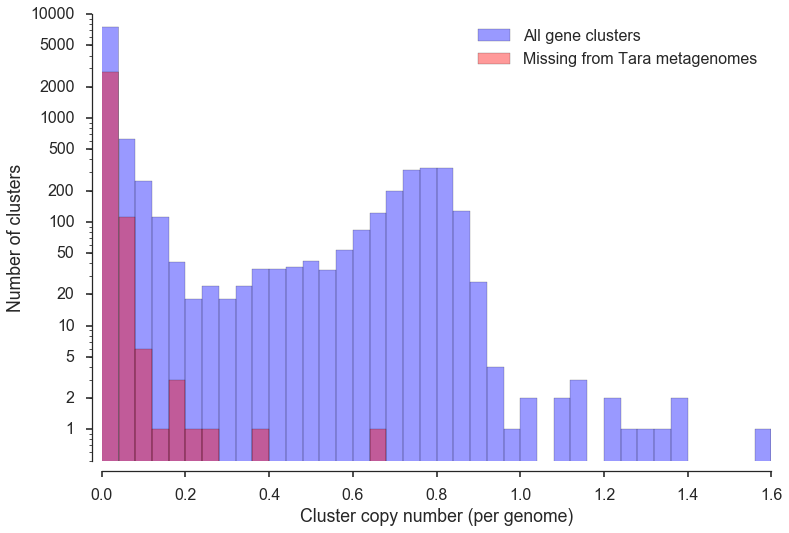

In [26]:
# full hist
plot_hist_tara(df_all_clusters, df_missing_clusters, 240, 5.8, 1.6001, num_genomes, 10000, fig_full)

In [27]:
# zoom hist
# plot_hist_tara(df_all_clusters, df_missing_clusters, 1.6201, num_genomes, 30, fig_zoom)

#### Density heatmap of Prochlorococcus gene clusters by cluster size (numer of genomes) and presence/absence in 139 Tara prokaryote metagenomes

In [28]:
df_size_count = make_df_size_count(df_all_clusters, df_counts)
groupby_size_count, max_size, max_count = make_groupby_size_count(df_size_count)

In [29]:
print groupby_size_count.max().max()

1904.0


In [30]:
# def fourth_root(num):
#     return num**0.25
# def square_root(num):
#     return num**0.5
# groupby_size_count_fourth_root = groupby_size_count_nonan.apply(fourth_root)
# groupby_size_count_square_root = groupby_size_count_nonan.apply(square_root)

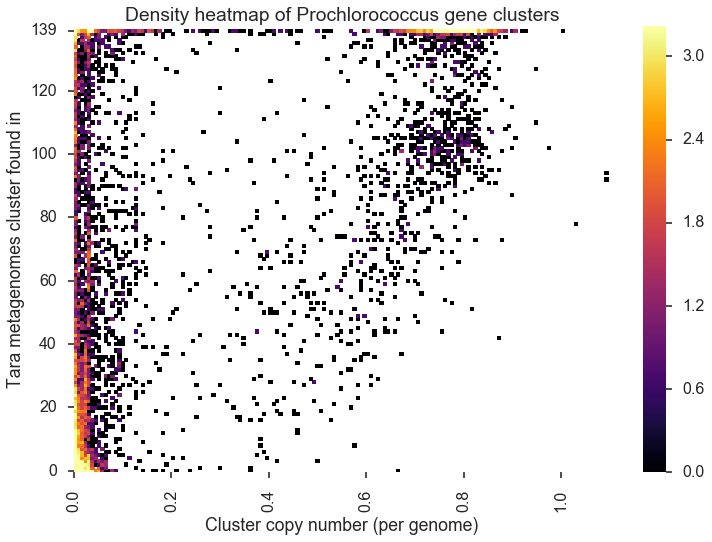

In [31]:
fig_path = '/Users/luke/singlecell/tara/heatmap_tara_proch.pdf'
plot_heatmap_tara(groupby_size_count, num_genomes, max_size, max_count, 1.1, 12, 8, 'Prochlorococcus', fig_path) # 1.1 was 1.62

/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


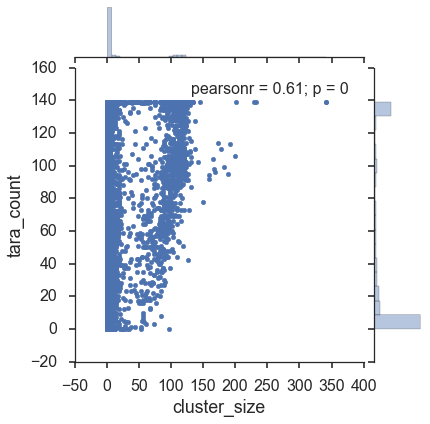

In [32]:
# jointplot of cluster_size and tara_count
fig = sns.jointplot(x='cluster_size', y='tara_count', data=df_size_count)

#### PELAGIBACTER

In [33]:
# missing clusters
path = '/Users/luke/singlecell/tara/table_missing_pelag_all_1e-5.tsv'
num_genomes = 47
fig_full = '/Users/luke/singlecell/tara/hist_missing_pelag_all_1e-5_full.pdf'
fig_zoom = '/Users/luke/singlecell/tara/hist_missing_pelag_all_1e-5_zoom.pdf'

df_missing_clusters = read_clusters_tsv(path)

In [34]:
# all clusters
path = '/Users/luke/singlecell/tara/table_all_pelag.tsv'

df_all_clusters = read_clusters_tsv(path)

/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.ru

In [35]:
# tara counts by cluster 
species = 'pelag'
evalue = '1e-5'
path = '/Users/luke/singlecell/tara/paths_%s_%s.list' % (species, evalue)

df_counts = merge_cluster_counts(path)
# col_SRF = [col for col in list(df_counts.columns) if 'SRF' in col]
# df_counts = df_counts[col_SRF]

In [36]:
df_counts.shape

(4475, 139)

#### Histograms of Pelagibacter gene cluster size among clusters MISSING in all Tara samples

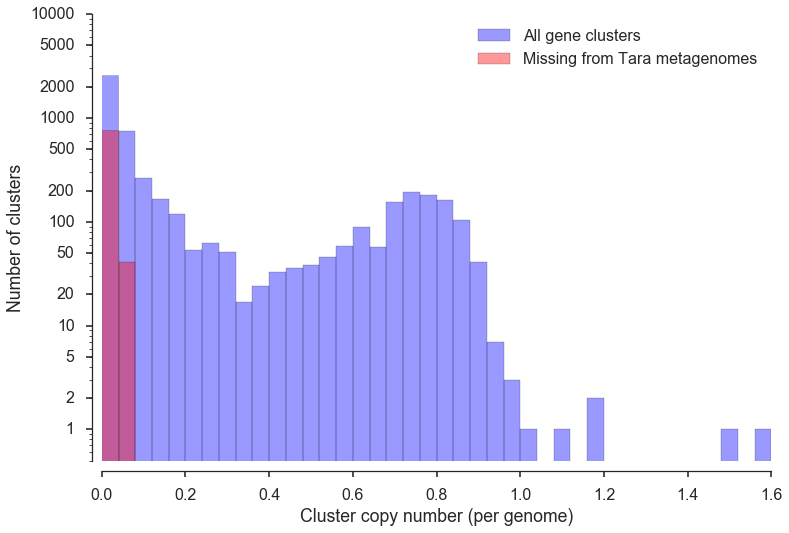

In [37]:
# full hist
plot_hist_tara(df_all_clusters, df_missing_clusters, 100, 1.88, 1.6001, num_genomes, 5000, fig_full)

In [38]:
# zoom hist
#plot_hist_tara(df_all_clusters, df_missing_clusters, 1.6201, num_genomes, 30, fig_zoom)

#### Density heatmap of Pelagibacter gene clusters by cluster size (numer of genomes) and presence/absence in 139 Tara prokaryote metagenomes

In [39]:
df_size_count = make_df_size_count(df_all_clusters, df_counts)
groupby_size_count, max_size, max_count = make_groupby_size_count(df_size_count)

In [40]:
print groupby_size_count.max().max()

756.0


In [44]:
groupby_size_count.max().max()

756.0

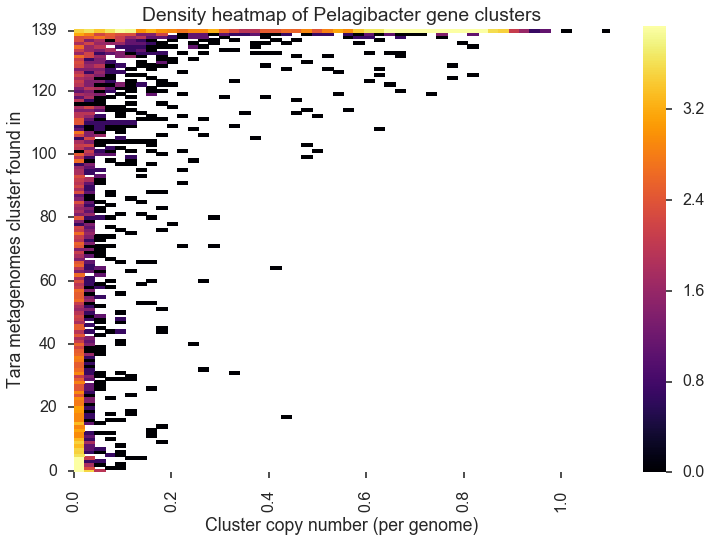

In [41]:
fig_path = '/Users/luke/singlecell/tara/heatmap_tara_pelag.pdf'
plot_heatmap_tara(groupby_size_count, num_genomes, max_size, max_count, 1.1, 12, 8, 'Pelagibacter', fig_path) # 1.1 was 1.62